# Performance comparison of 3D finite difference scalar wave propagation implementations
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

If you have been following along with my previous [1D](https://github.com/ar4/wave_1d_fd_perf/blob/master/notebooks/wave_1d_fd_perf.ipynb) and [2D](https://github.com/ar4/wave_2d_fd_perf/blob/master/notebooks/wave_2d_fd_perf.ipynb) wave propagation performance notebooks, it is probably no surprise that I am now going to look at 3D.

The idea is the same as before: how should I write my C or Fortran propagation code to get the best performance when called from Python. In all cases the propagation method is the same: a 16th order in space, 2nd order in time finite difference. What changes between implementations are the compiler flags, or the way the code is structured. As with the other dimensions, this is probably a memory bandwidth-limited computation, so it is likely that the best place to look for performance improvements is by avoiding unnecessary memory accesses. Processors and compilers are very complicated, however, and so it is often not possible to predict how a change will affect performance. This is why I believe the best strategy is to simply create many implementations and test them.

All implementations, with all of the compiler options tested, passed my correctness tests. This means that they produced wavefields that were within 1e-4 of the analytic result in a constant velocity model, and within 5e-8 of the simplest implementation (VC1 with `-O2` optimization) on a random model.

## Implementations

### [VC1](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc1.c)
This is the most obvious implementation, consisting of one function with five nested loops: (outside to inside) time steps, `z`, `y`, `x`, and the finite difference coefficients. The code is quite clear, and only 77 lines. One thing is a little ugly, though: the arrays are allocated as contiguous blocks in memory, so to access the array at `(x, y, z)`, I need to access element `[z * ny * nx + y * nx + x]`. This would make the code quite unpleasant to look at, so I defined a preprocessor macro to expand a simpler expression into this. This looks a bit cleaner, but is still not ideal.

### [VC2](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc2.c)
As in the 2D notebook, VC2 is the same as VC1, except that I manually unrolled the loop over finite difference coefficients. This makes the code quite a bit longer - in 3D VC2 is 124 lines long - but in 2D this optimization resulted in a significant performance improvement, so it may be justified.

### [VC3](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc3.c), [VC4](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc4.c)
As in 2D, VC3 and VC4 are modifications of VC1 and VC2, respectively, to separate the loops inside the time step loop into a separate function. This helps the compiler to vectorize the code, as otherwise the pointer swapping code at the end of each time step causes the compiler to be unsure that there is no pointer aliasing.

### [VC5](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc5.c), [VC6](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc6.c)
These use OpenMP on the loop over `z` (the outer spatial loop) to enable multithreaded parallel processing of VC3 and VC4, respectively.

### [VC7](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc7.c)
I was not able to find any compiler options that would cause GCC to unroll the loop over finite difference coefficients in VC1. Manually unrolling, as in VC2, works, but makes the code ugly and difficult to modify. VC7 is another modification of VC1 that avoids manual unrolling but still succeeds in getting GCC to unroll the loop.

### [VC8](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc8.c)
This is the same as VC6, but with cache blocking. To increase the chance that the data needed to calculate the Laplacian is stored in cache, rather than having to fetch it from main memory, this version operates on cubes rather than rows. 

### [VC9](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc9.c),  [VC10](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc10.c), [VC11](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc11.c)
These are modifications of VC1 to use AVX2 intrinsics for the calculations (there are minor variations in the code structure between these three versions). This ensures that there are no missed vectorization opportunities, but is undesirable in other ways. In particular, the code is harder to read, will not run on processors that do not support AVX2, and may not run well on future processors. Expanding on the last point: I am confident that in ten years VC1 will still give reasonable performance when compiled on the latest processors, and the compiler will ensure that it uses many of the new features that will be introduced by then. These versions that use AVX2 intrinsics restrict the ability of the compiler to make use of new processor features, and so may no longer give good performance.

### [VC12](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vc12.c)
This is VC9 with OpenMP parallelization of the `z` loop.

### [VF1](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vf1.f90), [VF2](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vf2.f90)
Fortran equivalents of VC1 and VC2. Fortran has an advantage of elegant array notation, so accessing the array at `(x, y, z)` is as easy as writing that, contrasting favourably with C.

### [VF3](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vf3.f90), [VF4](https://github.com/ar4/wave_3d_fd_perf/blob/master/wave_3d_fd_perf/vf4.f90)
VF1 and VF2 with OpenMP parallelization of the `z` loop, respectively.

In [1]:
from wave_3d_fd_perf import propagators, run_timing, run_timing_blocksize, test_wave_3d_fd_perf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                8
On-line CPU(s) list:   0-7
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Model name:            Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz
Stepping:              2
CPU MHz:               2397.201
BogoMIPS:              4794.40
Hypervisor vendor:     Microsoft
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              30720K
NUMA node0 CPU(s):     0-7
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx lm constant_tsc rep_good nopl eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm fsgsbase bmi1 avx2 sm

In [17]:
!gcc --version

gcc (Ubuntu 5.4.0-6ubuntu1~16.04.4) 5.4.0 20160609
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Results

### Block size
For the cache blocking implementation, VC8, we need to decide what size to make the blocks in `x`, `y`, and `z`. To do this, I will try a variety of different block size combinations and measure the runtime on several different model sizes. I use several model sizes to ensure that the optimal block size that we find is not tuned for a particular one.

In [9]:
blocksizes_x = [32, 64, 128, 256]
blocksizes_y = [1, 8, 16, 32]
blocksizes_z = [1, 8, 16, 32]
t8 = run_timing_blocksize.run_timing_model_size(num_repeat=1, num_steps=10, model_sizes=range(400, 600, 50), blocksizes_x=blocksizes_x, blocksizes_y=blocksizes_y, blocksizes_z=blocksizes_z, align=16)

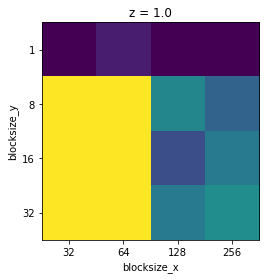

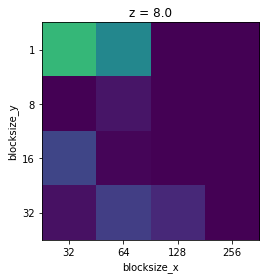

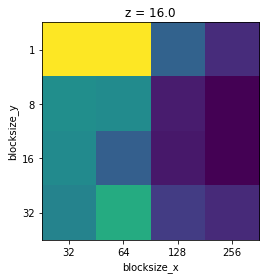

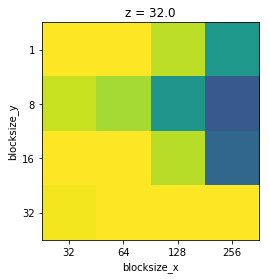

In [19]:
c0 = t8.groupby(['blocksize_y', 'blocksize_x']).mean()['time'].min()
c1 = t8.groupby(['blocksize_y', 'blocksize_x']).mean()['time'].max()
for z in t8['blocksize_z'].unique():
    plt.figure()
    plt.title('z = {}'.format(z))
    ax = plt.subplot(111)
    d=t8.loc[t8['blocksize_z']==z].groupby(['blocksize_y', 'blocksize_x']).mean()['time'].values.reshape(len(blocksizes_y), len(blocksizes_x))
    ax.imshow(d, clim=(c0, c1))
    plt.xlabel('blocksize_x')
    plt.ylabel('blocksize_y')
    ax.set_xticks(range(0,len(blocksizes_x)))
    ax.set_yticks(range(0,len(blocksizes_y)))
    ax.set_yticklabels(blocksizes_y);
    ax.set_xticklabels(blocksizes_x);

When I did the same experiment in 2D, the result (on the cloud instance, at least) showed that for the model sizes I considered, it was better to not use cache blocking at all. I speculated that the models weren't big enough, and that cache blocking would be more important in 3D because it would be more unlikely that the cache would store a whole row. It looks like I might have been right.

Although the performance is good when we don't use any cache blocking (the first row of the top image, where the block size is greater than 1 in only the `x` direction), the second image, where the block size in `z` is 8, contains a lot more configurations where the run time is low (purple).

We can check which configuration got the best run time out of all of those that I considered. I do this in the next cell, and find the best is when I use a block that has 8 cells in `z` and `y`, and 128 cells in `x`. This seems like a plausible result. Having a long block size in the `x` direction benefits from prefetching. I don't think there is any reason why the block size in `y` should be different to `z`, and so it also makes sense that these are the same. We need to find a compromise between wasting some prefetched data, and reusing cached data, and, for this system, this is what was found. 

In [18]:
t8.groupby(['blocksize_z', 'blocksize_y', 'blocksize_x']).mean()['time'].argmin()

(8.0, 8.0, 128.0)

### All implementations on a fixed model size

I will now run all of the different implementations for ten time steps on a 200 x 200 x 200 model.

In [3]:
t = run_timing.run_timing_model_size(num_repeat=30, num_steps=10, model_sizes=[200], align=16)

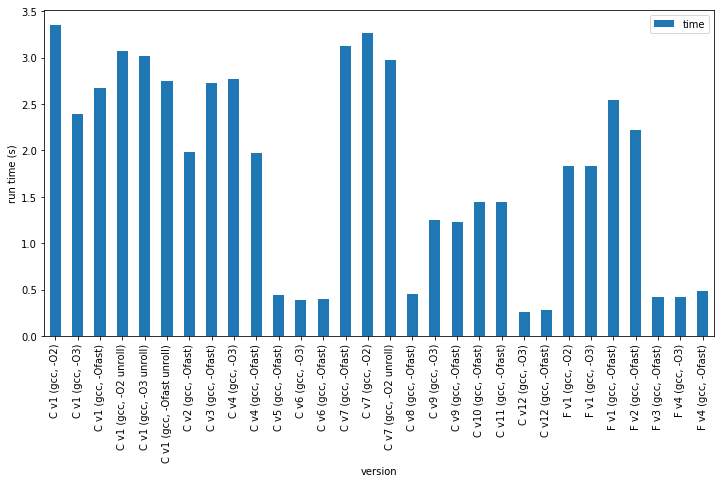

In [11]:
t.plot.bar(x='version', y='time', figsize=(12,6))
plt.ylabel('run time (s)')

This plot looks quite similar to the equivalent one in the 2D notebook, but there are some interesting observations to be made.

One surprise is that in several cases `-O3` outperformed `-Ofast`, whereas the latter was consistently faster in the 1D and 2D notebooks. This can be seen for VC1 (second column faster than third), VC6, VC9, VC12, VF1, and VF4. Exceptions are VC1 with `-funroll-loops`, and VC4, when `-Ofast` is faster. It is not unusual for higher optimization levels to do things that are detrimental to performance, but the fact that the best option seems to change when you go to 3D may catch some people out.

Manually unrolling the finite difference loop is again a very beneficial optimization, as shown by the big drop in run time between VC1 and VC2. The third to fifth columns, representing VC1 when compiled with `-funroll-loops` are there to show that even if we request unrolling, the compiler will not unroll this loop.

I did discover that with some alterations to the finite difference loop, rather than with compiler options alone, I was able to get the compiler to unroll the finite difference loop (it at least reports that it is doing so), but the performance of this version, VC7 is actually worse than VC1.

Multithreading with OpenMP is the most profitable optimization, with a big drop in run time for VC5, VC6, VC8, and VC12.

As in 2D, cache blocking again did not help in this test, with VC8 not running faster than VC6. My speculations about the cause of this in 2D continue to apply: the model may not be big enough, or it may be a possible effect of running on a cloud instance.

Hand vectorizing the code, used in VC9, VC10, VC11, and VC12, is quite beneficial. None of my versions that only use standard C without intrinsics were able to beat these. This is unfortunate, as I discussed above (reduced portability and maintainability), but the performance is undeniably impressive.

Fortran performed quite well in this test. None of the single-threaded standard (no intrinsics) C implementations matched VF1, and the multithreaded Fortran versions are comparable to VC6.


### Varying model size

To keep the run time down in the previous test, I ran on a fairly small model. Now that we have identified the implementations that look the most promising, I will try a few of them on larger models.

In [ ]:
versions=[{'class': propagators.VC6_O3_gcc, 'name': 'C v6 (gcc, -O3)'},
          {'class': propagators.VC8_Ofast_gcc, 'name': 'C v8 (gcc, -Ofast)'},
          {'class': propagators.VC12_O3_gcc, 'name': 'C v12 (gcc, -O3)'}]
t_modelsize=run_timing.run_timing_model_size(num_repeat=10, num_steps=10, model_sizes=np.linspace(200, 600, 5, dtype=np.int), versions=versions, align=16)

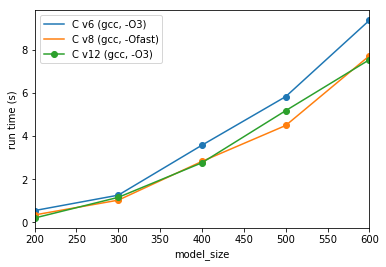

In [3]:
ax=plt.subplot(111)
for v in versions:
    t_modelsize.loc[t_modelsize['version'] == v['name']].plot(x='model_size', y='time', label=v['name'], ax=ax, style='o-')
plt.ylabel('run time (s)');

The 200 x 200 x 200 model size, the one I used when running all of the implementations, is the first result on this plot, and we see that the three chosen implementations perform quite similarly, as we saw before. This continues for the next model size, but then when we get to the 400 x 400 x 400 model, VC8 and VC12 start showing noticeably better performance than VC6. The performance divergence continues for larger model sizes.

I think we are finally seeing the benefit of cache blocking when we get to these larger model sizes. By the time we get to the 600 x 600 x 600 model, there is about a two second performance improvement when we use cache blocking. It is possible that the difference might have been even larger if I had used `-O3` to compile VC8 instead of `-Ofast`.

The benefit of using AVX2 intrinsics also continues at larger problem sizes. The results are very similar to those of VC8. It would be interesting to see if even further performance improvements could be obtained by adding cache blocking to VC12.


### Number of cells per second

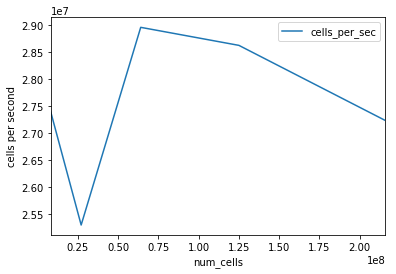

In [6]:
t_cellpersec = t_modelsize[t_modelsize['version'] == 'C v12 (gcc, -O3)'].copy()
t_cellpersec['num_cells'] = t_cellpersec['model_size']**3
t_cellpersec['cells_per_sec'] = t_cellpersec['num_cells'] / t_cellpersec['time']
t_cellpersec.plot(x='num_cells', y='cells_per_sec')
plt.ylabel('cells per second');

The number of cells we can process per second (where process means propagate ten time steps) is fairly constant across model sizes, around 2.7e7. That's about 2.7e8 cells per second for one time step, so, with eight 2.4 GHz cores, that's about 70 cycles per cell per time step.


### Conclusions

Many of the results were similar to the 2D case, but the change in whether `-O3` or `-Ofast` gives best performance was a surprise that demonstrates the importance of testing many configurations.

The top performing implementation on the small 200 x 200 x 200 model was VC12 with `-O3`. This is a manually vectorized code, using AVX2 instrinsics and OpenMP for multithreading. The use of intrinsics is unfortunate, but the performance benefits of such techniques in HPC codes sometimes overcome the disadvantages.

For larger model sizes, cache blocking became important. Applying this technique to VC6, to give VC8, led to about a 20% speed-up for the 600 x 600 x 600 model, and more might have been possible with different compiler options.